In [1]:
import pyomo.environ as pyo # import pyomo environment
import cProfile
import pstats
import io
from pyomo.common.timing import TicTocTimer, report_timing
from pyomo.opt.results import assert_optimal_termination
from pyomo.core.expr.numeric_expr import LinearExpression
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

In [11]:
def create_warehouse_model(num_locations=50, num_customers=50):
    N = list(range(num_locations)) # warehouse locations
    M = list(range(num_customers)) # customers
    max_num_warehouses = 2
    
    d = dict() # distances from warehouse locations to customers
    for n in N:
        for m in M:
            d[n, m] = np.random.randint(low=1, high=100)
    
    model = pyo.ConcreteModel(name="(WL)")
    
    model.P = pyo.Param(initialize=max_num_warehouses, mutable=True)
    
    model.x = pyo.Var(N, M, bounds=(0, 1))
    model.y = pyo.Var(N, bounds=(0, 1))
    
    def obj_rule(model):
        return sum(d[n,m]*model.x[n,m] for n in N for m in M)
    model.obj = pyo.Objective(rule=obj_rule)
    
    def demand_rule(model, m):
        return sum(model.x[n,m] for n in N) == 1
    model.demand = pyo.Constraint(M, rule=demand_rule)
    
    def warehouse_active_rule(model, n, m):
        return model.x[n,m] <= model.y[n]
    model.warehouse_active = pyo.Constraint(N, M, rule=warehouse_active_rule)
    
    def num_warehouses_rule(model):
        return sum(model.y[n] for n in N) <= model.P
    model.num_warehouses = pyo.Constraint(rule=num_warehouses_rule)
    
    return model

# report timing function

In [3]:
report_timing()
print("Building model")
print("---------------------")
model = create_warehouse_model(num_locations=200, num_customers=200)
print("---------------------")
print("Done!")

Building model
---------------------
           0 seconds to construct Block ConcreteModel; 1 index total
           0 seconds to construct Set Any; 1 index total
           0 seconds to construct Param P; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Set SetProduct_OrderedSet; 1 index total
           0 seconds to construct Set SetProduct_OrderedSet; 1 index total
        0.07 seconds to construct Var x; 40000 indices total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Var y; 200 indices total
        0.16 seconds to construct Objective obj; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
        0.08 seconds to construct Constraint demand; 200 indices total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to co

# tic toc timer

In [4]:
def solve_warehouse_location(m):
    opt = pyo.SolverFactory("glpk")
    res = opt.solve(m)
    assert_optimal_termination(res)

In [5]:
timer = TicTocTimer()
timer.tic("start")
m = create_warehouse_model(num_locations=200, num_customers=200)
timer.toc("Built model")
solve_warehouse_location(m)
timer.toc("Wrote LP file and solved")

[    0.00] start
           0 seconds to construct Block ConcreteModel; 1 index total
           0 seconds to construct Set Any; 1 index total
           0 seconds to construct Param P; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Set SetProduct_OrderedSet; 1 index total
           0 seconds to construct Set SetProduct_OrderedSet; 1 index total
        0.08 seconds to construct Var x; 40000 indices total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Var y; 200 indices total
        0.25 seconds to construct Objective obj; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
        0.15 seconds to construct Constraint demand; 200 indices total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Set OrderedS

65.09434670000002

## It is not yet clear what fraction of the 4.05 seconds is spent writing the LP file, which is where cProfile is useful

The **cProfile** package reports the time spent in **each function** and the **line profiler** package reports the time spent on **each line** of a function.

In [7]:
def solve_parametric():
    m = create_warehouse_model(num_locations=50, num_customers=50)
    opt = pyo.SolverFactory("glpk")
    p_values = list(range(1, 31))
    obj_values = list()
    for p in p_values:
        m.P.value = p
        res = opt.solve(m)
        assert_optimal_termination(res)
        obj_values.append(res.problem.lower_bound)

In [9]:
# function to print the results of the cprofile

def print_c_profiler(pr, lines_to_print=15):
    s = io.StringIO()
    stats = pstats.Stats(pr, stream=s).sort_stats("cumulative")
    stats.print_stats(lines_to_print)
    print(s.getvalue())
    s = io.StringIO()
    stats = pstats.Stats(pr, stream=s).sort_stats("tottime")
    stats.print_stats(lines_to_print)
    print(s.getvalue())

As described in the cProfile documentation, the cumulative time is the time spent in the corresponding function, including all functions called within the function. The total time is the time spent in the corresponding function, excluding all calls to functions within the specified function.

In [10]:
pr = cProfile.Profile()
pr.enable()
solve_parametric()
pr.disable()
print_c_profiler(pr)

           0 seconds to construct Block ConcreteModel; 1 index total
           0 seconds to construct Set Any; 1 index total
           0 seconds to construct Param P; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Set SetProduct_OrderedSet; 1 index total
           0 seconds to construct Set SetProduct_OrderedSet; 1 index total
        0.01 seconds to construct Var x; 2500 indices total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Var y; 50 indices total
        0.02 seconds to construct Objective obj; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
        0.01 seconds to construct Constraint demand; 50 indices total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index to

Note the 10.229 seconds reported by cProfile
is significantly longer than the 7.28 seconds reported by the TicTocTimer. Using cProfile does add some overhead to the code being profiled. Therefore,
cProfile should be used to identify bottlenecks (rather than comparing two algorithms, for example). 

solve_parametric                                                                       9.769 s
    solve:            pyomo call to solve                                              9.648 s
        write:        where the LP file is written                                     4.209 s
        apply_solver: where the subprocess command that calls the solver is executed   2.820 s

# Improving Model Construction Performance with LinearExpression

In [11]:
N1 = 10
N2 = 100000

m = pyo.ConcreteModel()

m.x = pyo.Var(list(range(N1)))

timer = TicTocTimer()

timer.tic()
for i in range(N2):
    e = sum(i*m.x[i] for i in range(N1))
timer.toc("created expression with sum function")

for i in range(N2):
    coefs = [i for i in range(N1)]
    lin_vars = [m.x[i] for i in range(N1)]
e = LinearExpression(constant=0, linear_coefs=coefs, linear_vars=lin_vars)
timer.toc("created expression with LinearExpression constructor")

           0 seconds to construct Block ConcreteModel; 1 index total
           0 seconds to construct Set OrderedScalarSet; 1 index total
           0 seconds to construct Var x; 10 indices total
[    0.00] Resetting the tic/toc delta timer
[+   3.97] created expression with sum function
[+   0.60] created expression with LinearExpression constructor


0.6039356999999654

# Repeated Solves with Persistent Solvers

Each time a Pyomo model is solved using the standard solver interfaces, the generalized modeling components defining the model must be translated into some input
form recognized by the solver in use. For cases where the solver finishes relatively
quickly, this model translation may introduce significant timing overhead. Persistent solver interfaces provide a mechanism for reducing overall translation time for
models that are solved repeatedly with incremental changes.

if the time spent solving the problem is
significantly longer than the time needed for translation, then little speedup will be
observed, but the complexity of the code may have increased. 

#  Basic Usage

In [2]:
m = pyo.ConcreteModel()
m.x = pyo.Var()
m.y = pyo.Var()
m.obj = pyo.Objective(expr=m.x**2 + m.y**2)
m.c = pyo.Constraint(expr=m.y >= -2*m.x + 5)

In [3]:
# pip install gurobipy
opt = pyo.SolverFactory("gurobi_persistent")
opt.set_instance(m)

results = opt.solve()

Restricted license - for non-production use only - expires 2023-10-25


any time the Pyomo model is changed, the persistent solver interface must be notified and kept in sync.

## add a constraint

In [5]:
m.c2 = pyo.Constraint(expr=m.y >= m.x)
opt.add_constraint(m.c2)

results = opt.solve()

## remove a constraint

In [7]:
opt.remove_constraint(m.c2)  # mandatory
del m.c2

results = opt.solve()

# variable modification

In [ ]:
m = pyo.ConcreteModel()

m.x = pyo.Var()
m.y = pyo.Var()

m.obj = pyo.Objective(expr=m.x**2 + m.y**2)

m.c = pyo.Constraint(expr=m.y >= -2*m.x + 5)

opt = pyo.SolverFactory("gurobi_persistent")
opt.set_instance(m)

m.x.setlb(1.0)
opt.update_var(m.x)

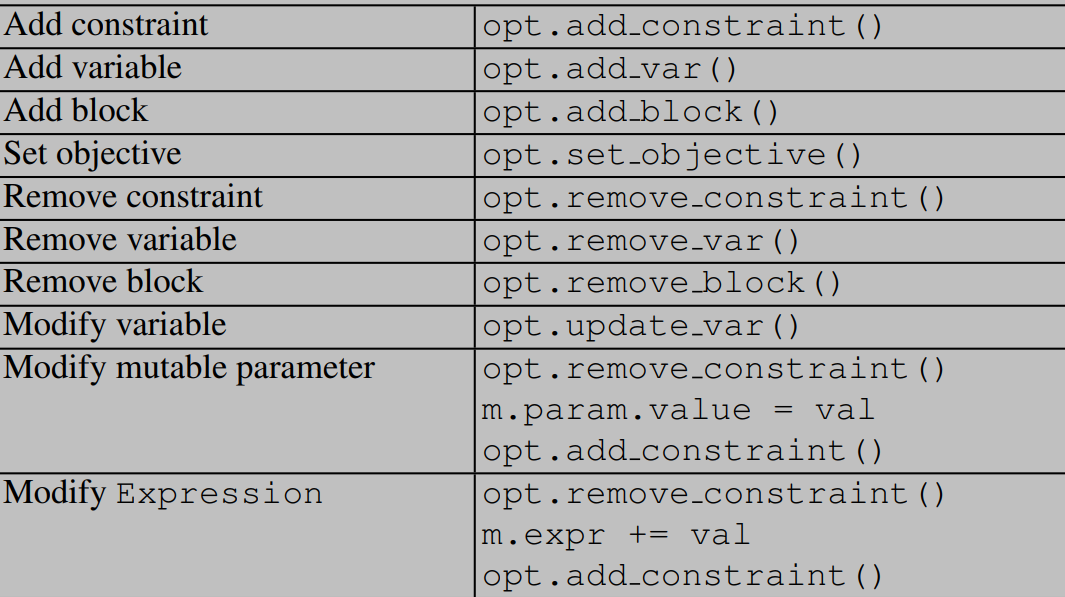

# Working with Indexed Variables and Constraints

In [ ]:
m.v = pyo.Var([0, 1, 2])
m.c2 = pyo.Constraint([0, 1, 2])
for i in range(3):
    m.c2[i] = m.v[i] == i
for v in m.v.values():
    opt.add_var(v)
for c in m.c2.values():
    opt.add_constraint(c)

# This must be done when removing indexed variables and constraints, too. 

In order to get the best performance out of the persistent solvers, use the
save results argument

In [ ]:
m = pyo.ConcreteModel()
m.x = pyo.Var()
m.y = pyo.Var()
m.obj = pyo.Objective(expr=m.x**2 + m.y**2)
m.c = pyo.Constraint(expr=m.y >= -2*m.x + 5)
opt = pyo.SolverFactory("gurobi_persistent")
opt.set_instance(m)
results = opt.solve(save_results=False)

Note that if the save results flag is set to False, then the following is not
supported.

In [ ]:
results = opt.solve(save_results=False, load_solutions=False)
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    try:
        m.solutions.load_from(results)
    except AttributeError:
        print("AttributeError was raised")

In [ ]:
results = opt.solve(save_results=False, load_solutions=False)
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    opt.load_vars()

# example

In [15]:
def solve_parametric_persistent():
    m = create_warehouse_model(num_locations=25, num_customers=25)
    
    opt = pyo.SolverFactory("gurobi_persistent")
    opt.set_instance(m)
    
    p_values = list(range(1, 31))
    obj_values = list()
    for p in p_values:
        
        m.P.value = p
        
        opt.remove_constraint(m.num_warehouses) # remove the constraint with the old value of p
        
        opt.add_constraint(m.num_warehouses)    # add the constraint with the new value of p
        
        res = opt.solve(save_results=False)
        
        assert_optimal_termination(res)
        obj_values.append(res.problem.lower_bound)

In [16]:
timer = TicTocTimer()
timer.tic("start")
solve_parametric_persistent()
timer.toc("Finished parameter sweep with persistent interface")

[    0.00] start
[+   0.59] Finished parameter sweep with persistent interface


0.5949065999998311